<a href="https://colab.research.google.com/github/mfischer-ucl/prdpt/blob/main/examples/box_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2D Example: Optimize Box Position 

A simple example with a more lightweight renderer. Task: optimize the box position. 

The plateau here originates from the fact that the boxes in the initial configuration do not overlap. 

Set the algorithm parameters in the sliders below and run the last cell to start the optimization. 


In [1]:
!git clone https://github.com/mfischer-ucl/prdpt
!cd prdpt

Cloning into 'prdpt'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 82 (delta 27), reused 71 (delta 20), pack-reused 0
Unpacking objects: 100% (82/82), 2.73 MiB | 7.22 MiB/s, done.


In [2]:
#@title Set up renderer

import os 
import torch
import functools
import numpy as np
import matplotlib.pyplot as plt 

device = 'cpu'
os.chdir('prdpt') 

from utils_fns import *
from utils_general import update_sigma_linear, run_scheduler_step, plt_errors, show_with_error


def get_rendering(theta, update_fn=None, ctx_args=None): 
  return draw_rect(theta[0], theta[1])


def draw_rect(px, py):   
  s, w, h, exp = 256, 0.1, 0.1, 10
  ss = torch.linspace(0, 1, s, device=device)
  x, y = torch.meshgrid(ss, ss)
  image = 1 - 2*(abs(((py - x)/w))**exp + abs((y - px)/h)**exp)
  return torch.flipud(image.clamp(0, 1)).unsqueeze(-1)


def render_smooth(perturbed_theta, update_fn, ctx_args):
  with torch.no_grad():
      imgs, losses = [], []
      for j in range(perturbed_theta.shape[0]):       # for each sample
          perturbed_img = get_rendering(perturbed_theta[j, :])
          perturbed_loss = torch.nn.MSELoss()(perturbed_img, ctx_args['gt_image'])
          imgs.append(perturbed_img)
          losses.append(perturbed_loss)

      avg_img = torch.mean(torch.cat([x.unsqueeze(0) for x in imgs], dim=0), dim=0)
      loss = torch.stack(losses)
  return loss, avg_img

In [3]:
#@title Set Algorithm Parameters { run: "auto", form-width: "25%", display-mode: "both" }
n_samples = 4 #@param {type:"slider", min:1, max:20, step:1}
sigma = 0.05 #@param {type:"slider", min:0.01, max:0.15, step:0.01}

hparams = {'nsamples': n_samples,
           'sigma': sigma,
           'learning_rate': 1e-3,
           'sigma_annealing': True,
           'epochs': 500,
           'anneal_const_first': 200,
           'anneal_const_last': 0,
           'anneal_sigma_min': 0.05
           }

torch.manual_seed(0)
sigma = hparams['sigma']

# set up initial and gt translation:
theta = torch.tensor([0.5, 0.66], requires_grad=True, device=device)
gt_theta = torch.tensor([0.5, 0.33], device=device)

# set up optim:
optim = torch.optim.Adam([theta], lr=hparams['learning_rate'])

init_img = get_rendering(theta)
ref_img = get_rendering(gt_theta)

# set up ctx_args: 
ctx_args = {'antithetic': True, 'nsamples': hparams['nsamples'], 'sigma': hparams['sigma'],
            'sampler': 'importance', 'device': device, 'gt_image': ref_img, 'update_fn': None}

/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


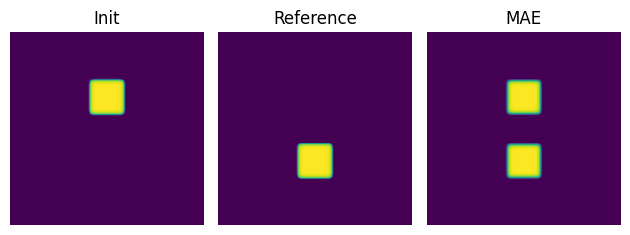

Iter 25/500 - Img.Loss: 0.0516 - Param.Loss: 0.0527
Iter 50/500 - Img.Loss: 0.0516 - Param.Loss: 0.0505


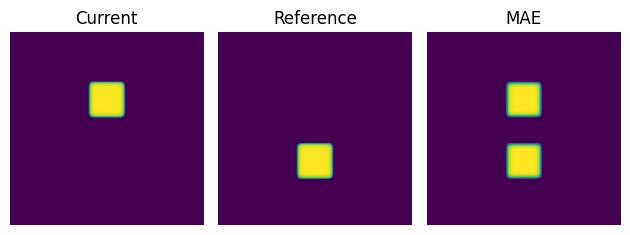

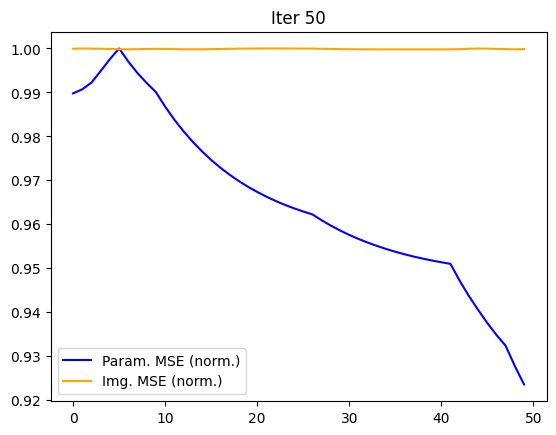

Iter 75/500 - Img.Loss: 0.0516 - Param.Loss: 0.0482
Iter 100/500 - Img.Loss: 0.0516 - Param.Loss: 0.0477


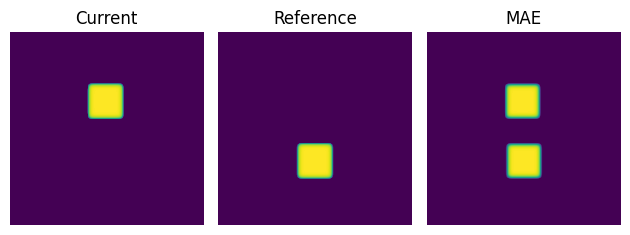

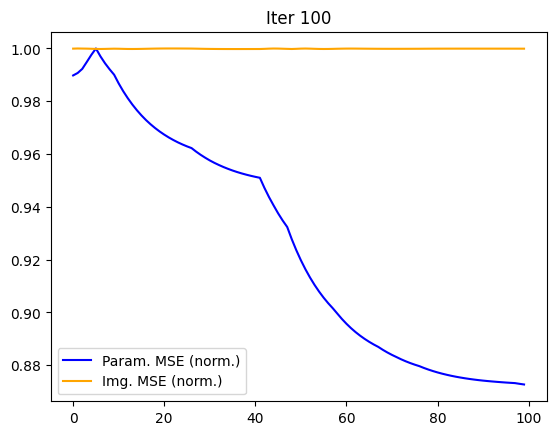

Iter 125/500 - Img.Loss: 0.0516 - Param.Loss: 0.0456
Iter 150/500 - Img.Loss: 0.0516 - Param.Loss: 0.0430


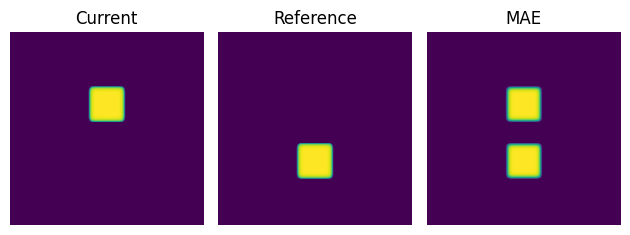

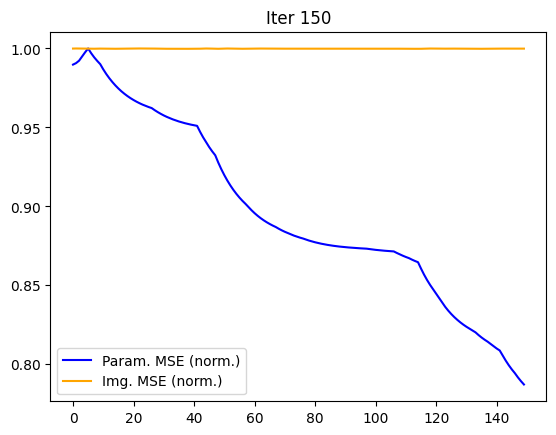

Iter 175/500 - Img.Loss: 0.0516 - Param.Loss: 0.0381
Iter 200/500 - Img.Loss: 0.0516 - Param.Loss: 0.0300


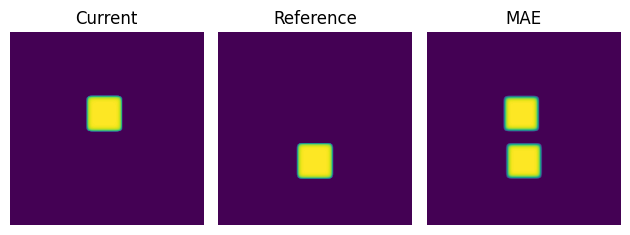

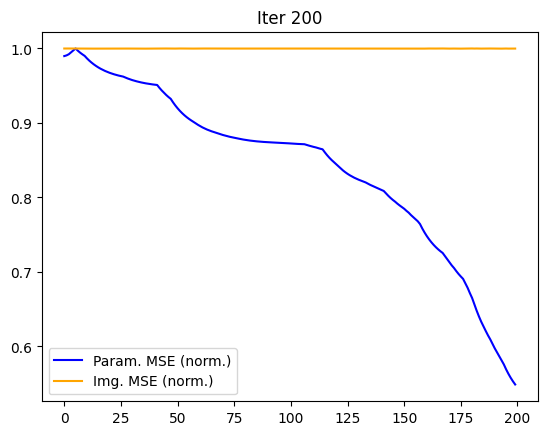

Iter 225/500 - Img.Loss: 0.0516 - Param.Loss: 0.0201
Iter 250/500 - Img.Loss: 0.0398 - Param.Loss: 0.0086


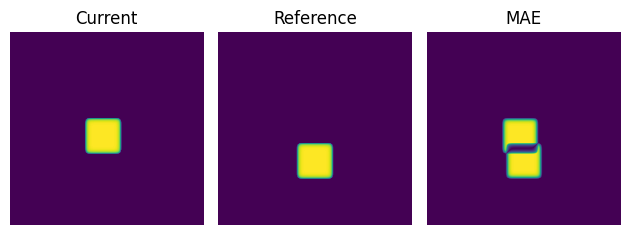

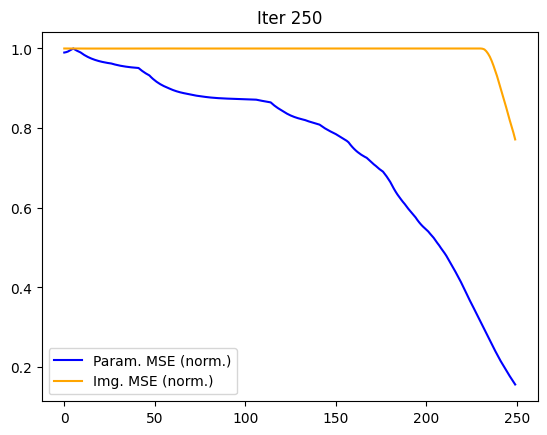

Iter 275/500 - Img.Loss: 0.0171 - Param.Loss: 0.0019
Iter 300/500 - Img.Loss: 0.0025 - Param.Loss: 0.0001


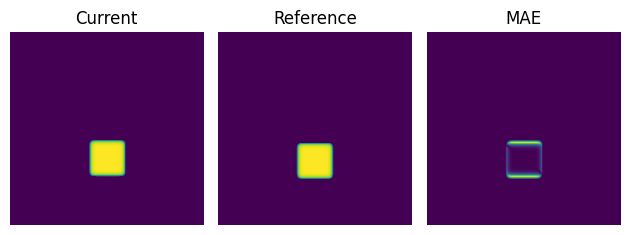

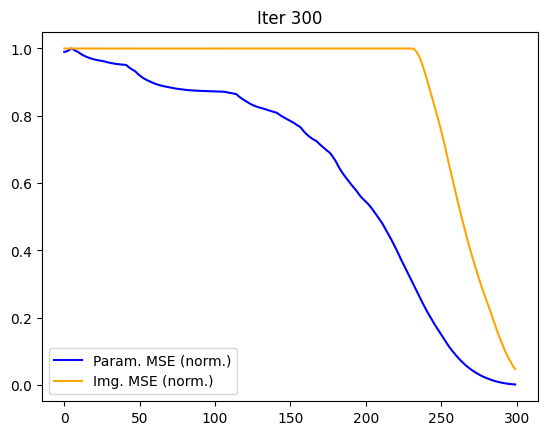

Iter 325/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 350/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000


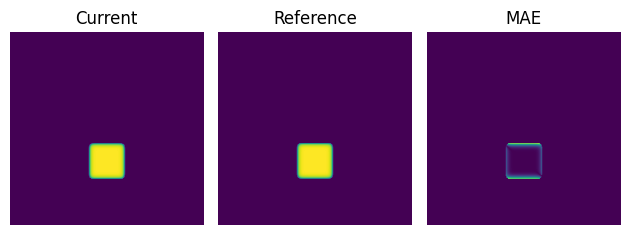

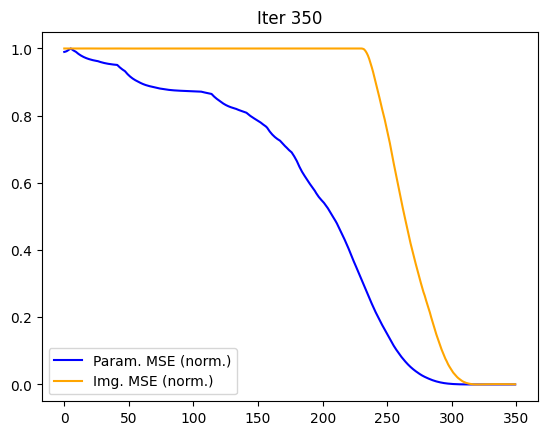

Iter 375/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 400/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000


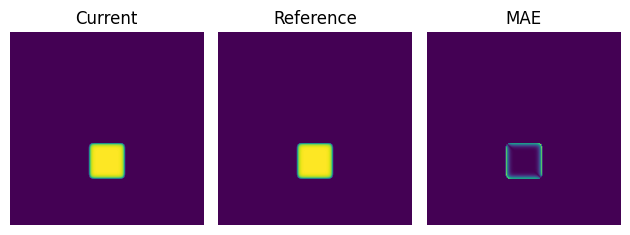

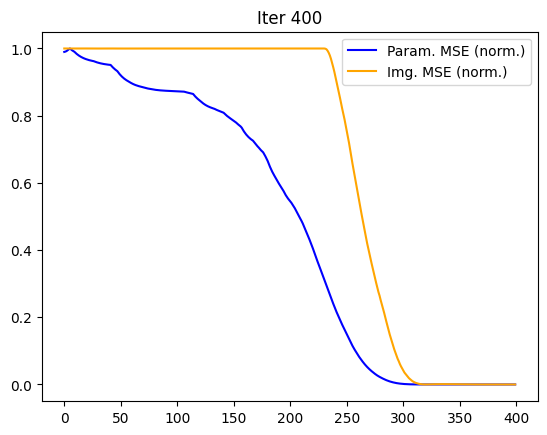

Iter 425/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 450/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000


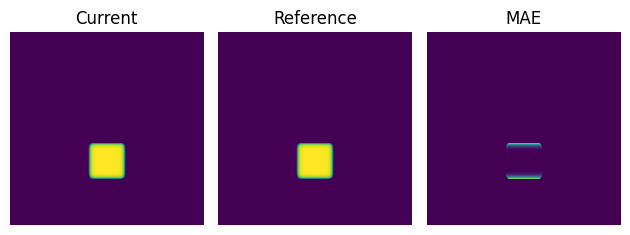

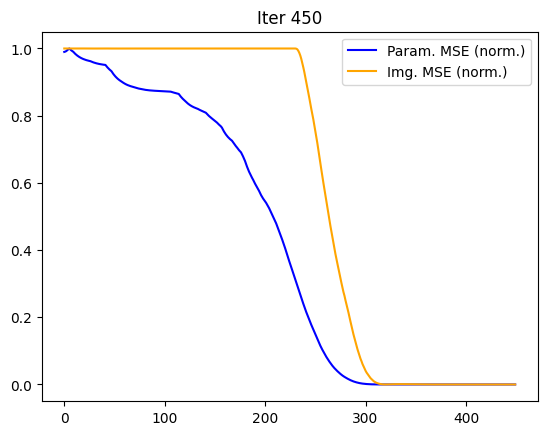

Iter 475/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 500/500 - Img.Loss: 0.0000 - Param.Loss: 0.0000


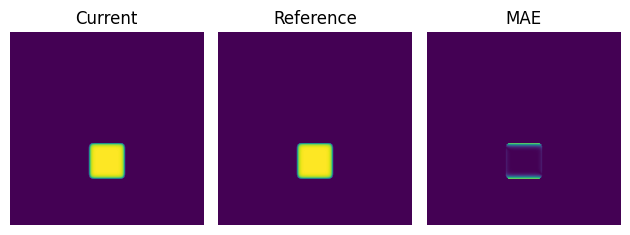

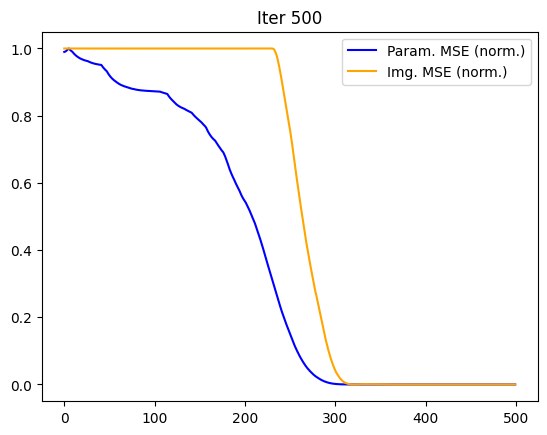

In [4]:
show_with_error(init_img, ref_img, iter=0)
# plt.rcParams['figure.figsize'] = (12, 6)

# set up smoothed renderer
get_smoothed_loss = smoothFn(render_smooth,
                             context_args=None,
                             device=ctx_args['device'])

img_errors, param_errors = [], []

# run optimization
for j in range(hparams['epochs']):
    optim.zero_grad()

    loss, _ = get_smoothed_loss(theta.unsqueeze(0), ctx_args)
    loss.backward()

    optim.step()

    # sigma scheduling:
    if j > hparams['anneal_const_first'] and hparams['sigma_annealing'] and sigma >= hparams['anneal_sigma_min']:
        sigma = run_scheduler_step(sigma, curr_iter=j+1, sigma_initial=hparams['sigma'], sigma_min=hparams['anneal_sigma_min'], 
                                   n=hparams['epochs'], const_first_n=hparams['anneal_const_first'], const_last_n=hparams['anneal_const_last'])
        ctx_args['sigma'] = sigma
    
    # plotting, logging, printing...
    img_curr = get_rendering(theta)
    img_loss = torch.nn.MSELoss()(img_curr, ref_img).item()
    param_loss = torch.nn.MSELoss()(theta, gt_theta).item()
    img_errors.append(img_loss)
    param_errors.append(param_loss)

    if (j+1) % 25 == 0: 
      print(f"Iter {j+1}/{hparams['epochs']} - Img.Loss: {img_loss:.4f} - Param.Loss: {param_loss:.4f}")

    if (j+1) % 50 == 0: 
      show_with_error(img_curr, ref_img, iter=j+1)
      plt_errors(img_errors, param_errors, title=f'Iter {j+1}')